## Дерево решений на примере iris_dataset и библиотеки sklearn

### Автоматический подбор параметров

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# Для жадного перебора
from sklearn.model_selection import GridSearchCV

# Для рандомного перебора
# from sklearn.model_selection import RandomizedSearchCV

from sklearn.datasets import load_iris

In [8]:
# Для отображения графики
from IPython.display import SVG
from graphviz import Source
from IPython.display import display

from IPython.display import HTML
style = "<style>svg{width:50% !important;height:50% !important;}</style>"
#HTML(style)

In [3]:
# Загружаем данные ирисов
iris = load_iris()
x = pd.DataFrame(iris.data).rename(columns={0: 'sepal_length', 
                   1: 'sepal width', 
                   2: 'petal length', 
                   3: 'petal width',
                   4: 'species'})
y = iris.target

In [4]:
# Разделим данные на train и test в пропорции 0,75/0,25
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.25, random_state=42)

In [5]:
# Создадим модель дерева с дефолтными настройками
dt = DecisionTreeClassifier()

In [6]:
# Определим параметры для теста лучшей модели
parametrs = {'criterion': ['gini', 'entropy'],
             'max_depth': range(1,10), 
             'min_samples_split': range(2,10), 
             'min_samples_leaf': range(1,10)}

In [7]:
# Найдем модель с лучшим качеством. Буду использовать жадный алгоритм перебора параметров. 
# Если необходимо быстро, но не точно - использую RandomizedSearchCV
search = GridSearchCV(dt, parametrs, cv=5)
search.fit(x_train,y_train)

# Определим лучшую модель
best_tree = search.best_estimator_

C:\Users\market1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


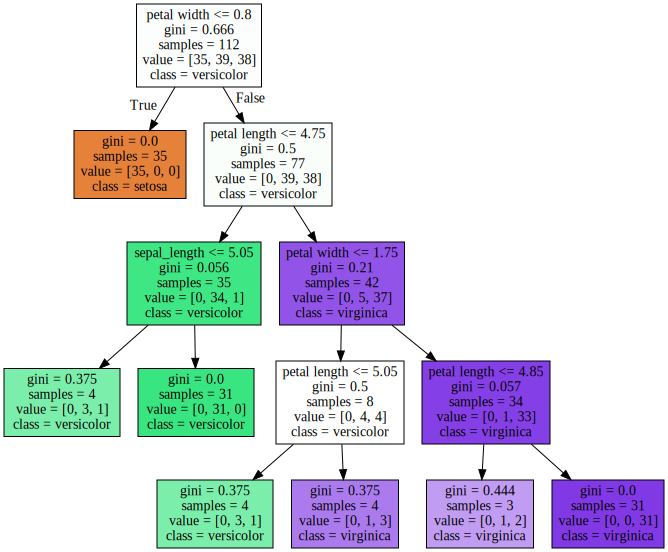

In [9]:
# Визуализация дерева
graph = Source(export_graphviz(best_tree, out_file=None
                                   , feature_names = list(x), class_names=['setosa', 'versicolor', 'virginica']
                                   , filled = True))
display(SVG(graph.pipe(format='svg')))

In [10]:
# Предскажем класс на тестовой выборке
predicted = best_tree.predict(x_test)

[Text(0, 0.5, 'setosa'), Text(0, 1.5, 'versicolor'), Text(0, 2.5, 'virginica')]

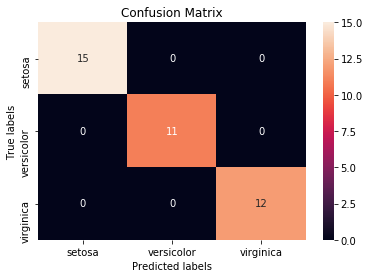

In [11]:
# Построим матрицу ошибок
df = confusion_matrix(y_test,predicted)

# Визуализируем матрицу
ax = plt.subplot()
sns.heatmap(df, annot=True, ax = ax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['setosa', 'versicolor', 'virginica'])
ax.yaxis.set_ticklabels(['setosa', 'versicolor', 'virginica'])

In [13]:
# Посмотрим точность модели
print('Точность модели:', accuracy_score(y_test,predicted))

Точность модели: 1.0


### 2. Кросс-валидация и цикл по одному параметру

In [21]:
from sklearn.metrics import precision_score
from sklearn.model_selection import cross_val_score

In [14]:
# Настройки для параметра по которому будем тюнить модель
max_depth_values = range(1,100)

# Дата фрейм для сбора статистики из цикла
scores_data = pd.DataFrame()

In [15]:
# Разделим данные на train и test в пропорции 0,75/0,25
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.25, random_state=4)

In [22]:
# Запустим цикл по параметру и будем собирать значения метрик на каждой итерации
for max_depth in max_depth_values:
    dt = DecisionTreeClassifier(max_depth=max_depth)
    dt.fit(x_train, y_train)
    
    train_score = dt.score(x_train, y_train)
    test_score = dt.score(x_test, y_test)
    
    predictions = dt.predict(x_test)
    precision = precision_score(y_test, predictions, average='micro')
    
    mean_cross = cross_val_score(dt, x_train, y_train, cv=5).mean()
    
    temp_score = pd.DataFrame({'max_depth': [max_depth],
                              'precision': [precision], 
                              'cross_val': [mean_cross], 
                              'train_score': [train_score],
                              'test_score': [test_score]})
    scores_data = scores_data.append(temp_score)

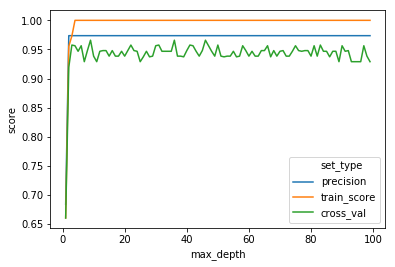

In [23]:
# Визуализируем метрики
scores_data_long = pd.melt(scores_data, id_vars=['max_depth'], value_vars=['precision','train_score', 'cross_val'],
                          var_name = 'set_type', value_name = 'score')

sns.lineplot(x='max_depth', y='score', hue='set_type', data=scores_data_long)

In [25]:
# Предскажем класс на тестовой выборке
predicted = dt.predict(x_test)

# Посмотрим точность модели
print('Точность модели:', accuracy_score(y_test,predicted))

Точность модели: 0.9736842105263158
